# Airbnb Seattle

In this project I picked the Airbnb seattle dataset, and try to find answers for the following questions:
1. When is the rush time for booking homestays at seattle?
2. For homestays unlike hotels, I care a lot about the host, so how to choose a host?
3. Does the host good communication and response means he is better than others?

In [50]:
# Import all needed libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

## 1. Data Investigation:

In [60]:
# read calendar dataset

calendar_df = pd.read_csv('data/calendar.csv')
calendar_df.info()
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
# check calendar data frame null values
print(np.sum(calendar_df.isnull())) 
print('')
print(calendar_df['available'].value_counts())
print('')
print("First date in the dataset: ", calendar_df['date'].min())
print("Last date in the dataset: ", calendar_df['date'].max())

listing_id         0
date               0
available          0
price         459028
dtype: int64

t    934542
f    459028
Name: available, dtype: int64

First date in the dataset:  2016-01-04
Last date in the dataset:  2017-01-02



- The calendar dataset consists of 4 columns, the column available has values (t, f) only.
- It is a one year data set, which means we can see the availability through different time of year.
- If the homestay is not availabe the column price is null otherwise has price value.
- This means for calendar data set, we have to work with availabe if 't' to to get prices.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

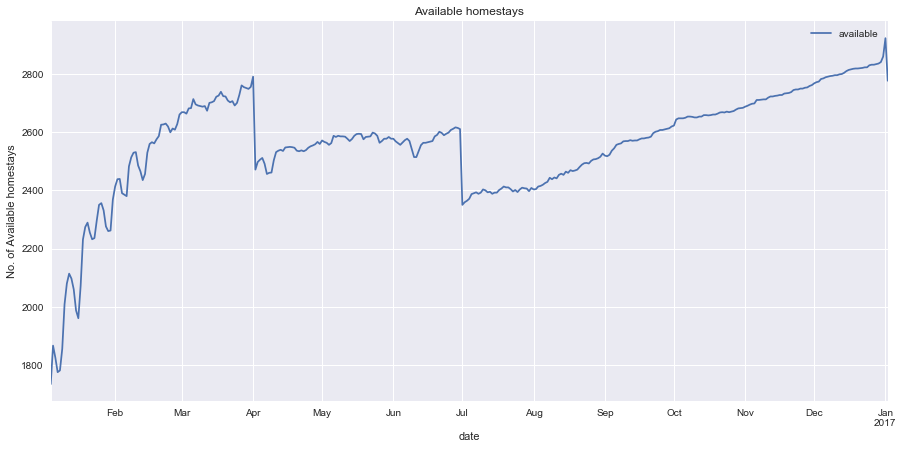

In [59]:
# get available homestays
available_df = calendar_df[(calendar_df.available == 't')]
#clean the price column  remove '$' to work with float numbers
available_df['price'] = available_df['price'].apply(lambda x: str(x).replace("$", ""))
available_df['price'] = pd.to_numeric(available_df['price'], errors="coerce")
available_df['date'] = pd.to_datetime(available_df['date'])
available_df.drop('listing_id', axis=1, inplace=True)
available_df.drop('price', axis=1, inplace=True)

plt.subplots(1, 1, figsize=(15, 7))
ax1=plt.subplot(1, 1, 1)
ax1.set_title('Available homestays')
ax1.set_ylabel('No. of Available homestays')
available_df.groupby(['date']).count().plot(ax=ax1)

- The graph shows that the least available homestays are at the begining of January, while the most available homestays are in December.
- The availability goes up from January to the end of March, goes down at the begining of April, and at the end of June.

In [5]:
# read listings dataset
# it includes full descriptions and average review score

listings_df = pd.read_csv('data/listings.csv')
listings_df.info()
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
# read reviews data set
# includes unique id for each reviewer and detailed comments

reviews_df = pd.read_csv('data/reviews.csv')
reviews_df.info()
reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84832 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [7]:
#how many rows and columns in the calendar_df
print("No.of rows and columns in calendar_df : ", calendar_df.shape)

#how many rows and columns in the listings_df
print("No.of rows and columns in listings_df : ", listings_df.shape)

#how many rows and columns in the reviews_df
print("No.of rows and columns in reviews_df : ", reviews_df.shape)

No.of rows and columns in calendar_df :  (1393570, 4)
No.of rows and columns in listings_df :  (3818, 92)
No.of rows and columns in reviews_df :  (84849, 6)


- After checking all the data sets, I think the most important for my objective will be listings dataset.
- The listings dataset should be merged with calender dataset to get full details and occupations about homestays.
- When analyzing the features in the listings dataset, I picked up the most important for me.

In [8]:
# Chosen features from listings dataset
minimized_listings_df = listings_df[['id', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_identity_verified', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'cancellation_policy']]

In [9]:
minimized_listings_df.info()
minimized_listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 10 columns):
id                        3818 non-null int64
host_response_time        3295 non-null object
host_response_rate        3295 non-null object
host_is_superhost         3816 non-null object
host_identity_verified    3816 non-null object
minimum_nights            3818 non-null int64
maximum_nights            3818 non-null int64
number_of_reviews         3818 non-null int64
review_scores_rating      3171 non-null float64
cancellation_policy       3818 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 298.4+ KB


,id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,cancellation_policy
0,241032,within a few hours,96%,f,t,1,365,207,95.0,moderate
1,953595,within an hour,98%,t,t,2,90,43,96.0,strict
2,3308979,within a few hours,67%,f,t,4,30,20,97.0,strict
3,7421966,NaN,NaN,f,t,1,1125,0,NaN,flexible
4,278830,within an hour,100%,f,t,1,1125,38,92.0,strict


In [10]:
# merge listings dataset with calendar dataset

minimized_listings_df = minimized_listings_df.rename(index=str, columns={"id": "listing_id"})
working_listings_df = pd.merge(calendar_df[['listing_id', 'date', 'available']], minimized_listings_df, on = 'listing_id')
working_listings_df.info()
working_listings_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 12 columns):
listing_id                1393570 non-null int64
date                      1393570 non-null object
available                 1393570 non-null object
host_response_time        1202675 non-null object
host_response_rate        1202675 non-null object
host_is_superhost         1392840 non-null object
host_identity_verified    1392840 non-null object
minimum_nights            1393570 non-null int64
maximum_nights            1393570 non-null int64
number_of_reviews         1393570 non-null int64
review_scores_rating      1157415 non-null float64
cancellation_policy       1393570 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 138.2+ MB


,listing_id,date,available,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,cancellation_policy
0,241032,2016-01-04,t,within a few hours,96%,f,t,1,365,207,95.0,moderate
1,241032,2016-01-05,t,within a few hours,96%,f,t,1,365,207,95.0,moderate
2,241032,2016-01-06,f,within a few hours,96%,f,t,1,365,207,95.0,moderate
3,241032,2016-01-07,f,within a few hours,96%,f,t,1,365,207,95.0,moderate
4,241032,2016-01-08,f,within a few hours,96%,f,t,1,365,207,95.0,moderate


## 2. Data Preprocessing:

In [11]:
# Check host_response_rate feature
# remove % sign and convert to numeric value

working_listings_df['host_response_rate'] = working_listings_df['host_response_rate'].apply(lambda x: str(x).replace("%", ""))
working_listings_df['host_response_rate'] = pd.to_numeric(working_listings_df['host_response_rate'], errors="coerce")
working_listings_df.info()
print('')

# check unique values, and if there is null values
print(working_listings_df['host_response_rate'].value_counts(dropna=False))
working_listings_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 12 columns):
listing_id                1393570 non-null int64
date                      1393570 non-null object
available                 1393570 non-null object
host_response_time        1202675 non-null object
host_response_rate        1202675 non-null float64
host_is_superhost         1392840 non-null object
host_identity_verified    1392840 non-null object
minimum_nights            1393570 non-null int64
maximum_nights            1393570 non-null int64
number_of_reviews         1393570 non-null int64
review_scores_rating      1157415 non-null float64
cancellation_policy       1393570 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 138.2+ MB

 100.0    865415
NaN       190895
 90.0      60225
 80.0      37960
 99.0      28470
 88.0      24090
 50.0      18980
 94.0      16790
 67.0      14965
 89.0      11680
 75.0      11680
 86.0      10950
 96.0      10220
 98

,listing_id,date,available,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,cancellation_policy
0,241032,2016-01-04,t,within a few hours,96.0,f,t,1,365,207,95.0,moderate
1,241032,2016-01-05,t,within a few hours,96.0,f,t,1,365,207,95.0,moderate
2,241032,2016-01-06,f,within a few hours,96.0,f,t,1,365,207,95.0,moderate
3,241032,2016-01-07,f,within a few hours,96.0,f,t,1,365,207,95.0,moderate
4,241032,2016-01-08,f,within a few hours,96.0,f,t,1,365,207,95.0,moderate


#### Chech and re-encoding the data

In [12]:
# Check available feature
# convert t to 1 and f to 0

working_listings_df['available'] = working_listings_df['available'].apply(lambda x: str(x).replace("t", "1"))
working_listings_df['available'] = working_listings_df['available'].apply(lambda x: str(x).replace("f", "0"))
working_listings_df['available'] = pd.to_numeric(working_listings_df['available'], errors="coerce")
# check unique values, and if there is null values
working_listings_df['available'].value_counts(dropna=False)

1    934542
0    459028
Name: available, dtype: int64

In [13]:
# Check host_is_superhost feature
working_listings_df['host_is_superhost'].value_counts(dropna=False)

f      1108870
t       283970
NaN        730
Name: host_is_superhost, dtype: int64

In [14]:
# convert t to 1 and f to 0
working_listings_df['host_is_superhost'] = working_listings_df['host_is_superhost'].apply(lambda x: str(x).replace("t", "1"))
working_listings_df['host_is_superhost'] = working_listings_df['host_is_superhost'].apply(lambda x: str(x).replace("f", "0"))
working_listings_df['host_is_superhost'] = pd.to_numeric(working_listings_df['host_is_superhost'], errors="coerce")

# check unique values, and if there is null values
working_listings_df['host_is_superhost'].value_counts(dropna=False)

 0.0    1108870
 1.0     283970
NaN         730
Name: host_is_superhost, dtype: int64

In [15]:
# Check host_identity_verified feature
working_listings_df['host_identity_verified'].value_counts(dropna=False)

t      1093905
f       298935
NaN        730
Name: host_identity_verified, dtype: int64

In [16]:
# convert t to 1 and f to 0
working_listings_df['host_identity_verified'] = working_listings_df['host_identity_verified'].apply(lambda x: str(x).replace("t", "1"))
working_listings_df['host_identity_verified'] = working_listings_df['host_identity_verified'].apply(lambda x: str(x).replace("f", "0"))
working_listings_df['host_identity_verified'] = pd.to_numeric(working_listings_df['host_identity_verified'], errors="coerce")
# check unique values, and if there is null values
working_listings_df['host_identity_verified'].value_counts(dropna=False)

 1.0    1093905
 0.0     298935
NaN         730
Name: host_identity_verified, dtype: int64

In [17]:
for col in working_listings_df[['available','host_response_time','host_response_rate','host_is_superhost','host_identity_verified', 'minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','cancellation_policy']].columns:
    print(working_listings_df[col].value_counts(dropna=False))

1    934542
0    459028
Name: available, dtype: int64
within an hour        617580
within a few hours    353320
within a day          217905
NaN                   190895
a few days or more     13870
Name: host_response_time, dtype: int64
 100.0    865415
NaN       190895
 90.0      60225
 80.0      37960
 99.0      28470
 88.0      24090
 50.0      18980
 94.0      16790
 67.0      14965
 89.0      11680
 75.0      11680
 86.0      10950
 96.0      10220
 98.0      10220
 70.0       9125
 97.0       7665
 83.0       7300
 60.0       7300
 93.0       6570
 92.0       6570
 33.0       5110
 40.0       4380
 63.0       4015
 78.0       2920
 71.0       2920
 95.0       2920
 91.0       1825
 43.0       1460
 64.0       1095
 76.0       1095
 87.0       1095
 25.0       1095
 17.0        730
 57.0        730
 58.0        730
 82.0        730
 81.0        365
 65.0        365
 56.0        365
 55.0        365
 53.0        365
 68.0        365
 69.0        365
 30.0        365
 38.0        3

##### Assess Missing Data:

- I converted all features that has binary choises "true, false" to numeric.
- Next step is to start dealing with nan values in these features.
- Also there is "host_response_time" feature that has nan values.

##### My action will be:

- For "host_is_superhost" and "host_identity_verified", the nan values will wbe replaced with 0.
- For "host_response_rate" and "review_scores_rating", the nan values will wbe replaced with minimum value in these features.
- For "host_response_time", nan values will be wreplaced with "a few days or more"
- I choosed these value so as not to give these records any periority over others, Also could use mean values.
- For features that has multiple string values "host_response_time" and "cancellation_policy", a dummy varaiables will be generated.



In [19]:
# Replace nan with 'a few days or more'
working_listings_df['host_response_time'].fillna('a few days or more', inplace = True)

# Replace nan with minimum value
working_listings_df['host_response_rate'].fillna(working_listings_df['host_response_rate'].min(), inplace = True)
working_listings_df['review_scores_rating'].fillna(working_listings_df['review_scores_rating'].min(), inplace = True)

# Replace nan with 0
working_listings_df['host_is_superhost'].fillna(0, inplace = True)
working_listings_df['host_identity_verified'].fillna(0, inplace = True)

In [20]:
# Double check for nan values
for col in working_listings_df[['available','host_response_time','host_response_rate','host_is_superhost','host_identity_verified', 'minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','cancellation_policy']].columns:
    print(working_listings_df[col].value_counts(dropna=False))

1    934542
0    459028
Name: available, dtype: int64
within an hour        617580
within a few hours    353320
within a day          217905
a few days or more    204765
Name: host_response_time, dtype: int64
100.0    865415
17.0     191625
90.0      60225
80.0      37960
99.0      28470
88.0      24090
50.0      18980
94.0      16790
67.0      14965
75.0      11680
89.0      11680
86.0      10950
96.0      10220
98.0      10220
70.0       9125
97.0       7665
60.0       7300
83.0       7300
93.0       6570
92.0       6570
33.0       5110
40.0       4380
63.0       4015
78.0       2920
71.0       2920
95.0       2920
91.0       1825
43.0       1460
76.0       1095
87.0       1095
64.0       1095
25.0       1095
82.0        730
58.0        730
57.0        730
38.0        365
55.0        365
53.0        365
81.0        365
56.0        365
30.0        365
65.0        365
68.0        365
69.0        365
31.0        365
Name: host_response_rate, dtype: int64
0.0    1109600
1.0     283970
Na

In [21]:
# Generate dummy variables
encodded_features = pd.get_dummies(working_listings_df[['host_response_time','cancellation_policy']])
encodded_features.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0,0,1,0,0,1,0
1,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0
3,0,0,1,0,0,1,0
4,0,0,1,0,0,1,0


In [22]:
# drop original features as there is dummy ones
working_listings_df = working_listings_df.drop(['host_response_time', 'cancellation_policy'], axis=1)

In [23]:
# merge generated dummy variables with the dataset
working_listings_df = working_listings_df.join(encodded_features)
working_listings_df.info()
working_listings_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 17 columns):
listing_id                               1393570 non-null int64
date                                     1393570 non-null object
available                                1393570 non-null int64
host_response_rate                       1393570 non-null float64
host_is_superhost                        1393570 non-null float64
host_identity_verified                   1393570 non-null float64
minimum_nights                           1393570 non-null int64
maximum_nights                           1393570 non-null int64
number_of_reviews                        1393570 non-null int64
review_scores_rating                     1393570 non-null float64
host_response_time_a few days or more    1393570 non-null uint8
host_response_time_within a day          1393570 non-null uint8
host_response_time_within a few hours    1393570 non-null uint8
host_response_time_within an hour        13935

,listing_id,date,available,host_response_rate,host_is_superhost,host_identity_verified,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,241032,2016-01-04,1,96.0,0.0,1.0,1,365,207,95.0,0,0,1,0,0,1,0
1,241032,2016-01-05,1,96.0,0.0,1.0,1,365,207,95.0,0,0,1,0,0,1,0
2,241032,2016-01-06,0,96.0,0.0,1.0,1,365,207,95.0,0,0,1,0,0,1,0
3,241032,2016-01-07,0,96.0,0.0,1.0,1,365,207,95.0,0,0,1,0,0,1,0
4,241032,2016-01-08,0,96.0,0.0,1.0,1,365,207,95.0,0,0,1,0,0,1,0



- After preparing the data, I will try to find correlations between variable.
- To find out which host is good and more popular, The "review_scores_rating" feature will be my target.


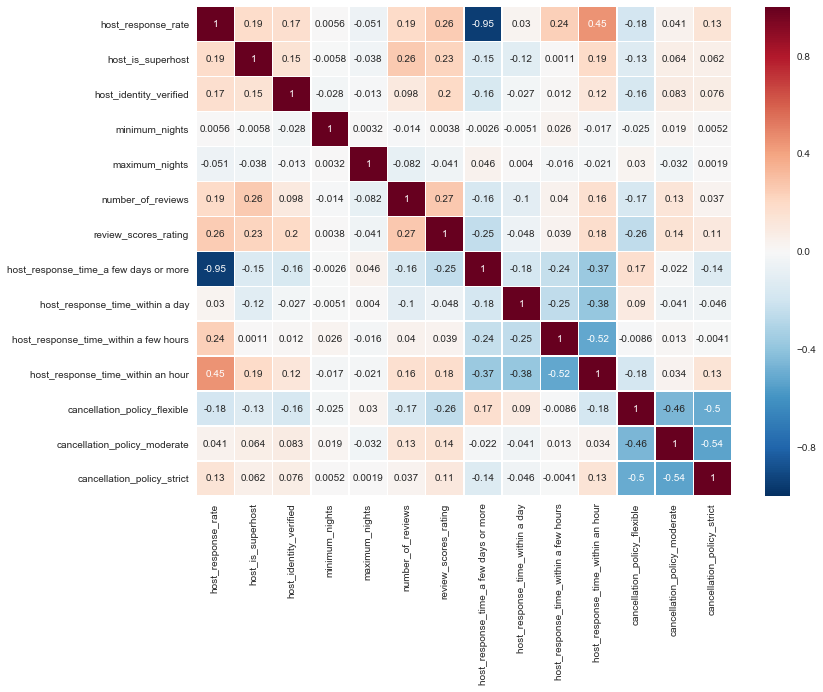

In [41]:
# Generate heat map to view the correlation between variables

working_listings_df_training = working_listings_df.drop(['listing_id','date','available'], axis=1)
fig, ax = plt.subplots(figsize=(12,9))
corr = working_listings_df_training.corr()
corr = (corr)
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, ax=ax)

In [38]:
corr['review_scores_rating'].sort_values(ascending=False)

review_scores_rating                     1.000000
number_of_reviews                        0.267120
host_response_rate                       0.257374
host_is_superhost                        0.226405
host_identity_verified                   0.199363
host_response_time_within an hour        0.175956
cancellation_policy_moderate             0.141072
cancellation_policy_strict               0.106340
host_response_time_within a few hours    0.039028
minimum_nights                           0.003806
maximum_nights                          -0.040648
host_response_time_within a day         -0.048050
host_response_time_a few days or more   -0.245548
cancellation_policy_flexible            -0.256304
Name: review_scores_rating, dtype: float64


- It seems there is a strong relation between the "review_scores_rating" and "number_of_reviews"
- It seems also that there is a strong relation between "review_scores_rating" and "host_is_superhost", and between "review_scores_rating" and "host_response_rate"


### 3. Modeling:

I will use RandomForestClassifier to train and classify the dataset.


In [45]:
# split the dataset to features and labels
features = working_listings_df_training.drop('review_scores_rating', axis=1)
labels = working_listings_df_training[['review_scores_rating']]

# split the features and labels to train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=165)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


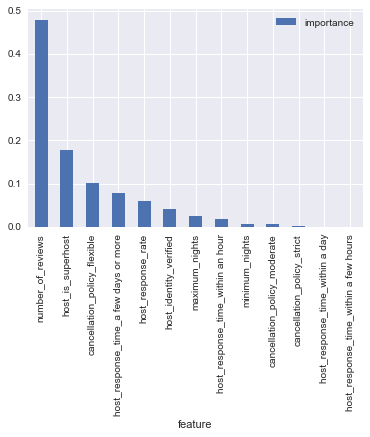

In [46]:
# Initialize the RandomForestClassifier, then fit 
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)  

# Extract features importance
clf_listings = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
clf_listings.sort_values(by='importance',ascending=False).plot(x='feature', y='importance', kind='bar')


In [47]:
# Test the model 
y_predict = clf.predict(X_test)

In [52]:
# Generate mean squared error and R squared score

print('MSE : %.3f' % mean_squared_error(y_test, y_predict))
print('R^2 score: %.3f' % r2_score(y_test, y_predict))

MSE : 93.146
R^2 score: 0.886


### Conclusion:

I started investigating this dataset trying to find answers to the questions that people are heading to seattle may ask, beside the common question about prices, families and individuals try to find the best homestay with the best host and the best time of the year to find available homestays.

And as a result of my investigating the data, from the heat map and feature importance xhart it seems that the visitors should seek the host that has a lot of reviews, check if he is categorized as a super host.
Also if the host has a flexible cancelation policy and a good response rate "interaction and communication"

Something strange I found from the feature importance chart that if the host respond in a few days or more this means he is good, but I think this happened because I add the value "a few days or more" instead of null in the dataset which should be revised to add the most common value.

Finally, these are my results, it could be enhanced by using other classifications or some tweaking for the classification parameters and it could be applied to other cities as will